In [50]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from tqdm import tqdm
import time


In [51]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Function

In [53]:
def get_pn_df(df, grp):

    # find the user_location with the most appearences
    a = df[grp].value_counts()
    print("Most appearences :")
    display(a)

    #keep only the ones with more than 5 appearences
    a = a[a > 5]
    #display(a)

    #remove all the lines of df_short that are not in a
    df = df[df[grp].isin(a.index)]
    
    # group neg by grp
    df_neg = df.groupby([grp])['neg'].apply(list).reset_index()
    df_neg['mean'] = df_neg['neg'].apply(np.mean)
    df_neg['median'] = df_neg['neg'].apply(np.median)
    #display(df_neg)

    # group pos by user_location
    df_pos = df.groupby([grp])['pos'].apply(list).reset_index()
    df_pos['mean'] = df_pos['pos'].apply(np.mean)
    df_pos['median'] = df_pos['pos'].apply(np.median)
    #display(df_pos)

    
    return df_neg, df_pos

In [55]:
def set_map():
    # Load shapefiles
    world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
    states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')
    uk = gpd.read_file('../data/shapefiles/infuse_ctry_2011_clipped.zip')

    # clean world
    world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
    world_clean = world_clean[world_clean['name'] != 'U.K. of Great Britain and Northern Ireland'][['name','geometry']]
    
    # clean states
    states.ste_name = states.ste_name.str.replace("['", "")
    states.ste_name = states.ste_name.str.replace("']", "")
    states_clean = states[['ste_name','geometry']]
    states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

    # clean uk
    uk_clean = uk[['geo_label','geometry']]
    uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)
    uk_clean = uk_clean.to_crs(world_clean.crs)
    #display(uk_clean)


    # concatenate
    shapefile = pd.concat([world_clean, states_clean, uk_clean], axis=0)

    #cleaning
    shapefile['name'] = shapefile['name'].str.replace("Moldova, Republic of", "Moldova")


    # display the duplicates in shapefile['name]
    shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

    # remove duplicates
    shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')
    print("ducplicates :")
    display(shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name'))
    print("shapefile names:")
    display(shapefile['name'])
    return shapefile

In [68]:
def plot_map(df, shapefile, title, set, col):
    sf_maincat = shapefile.copy()

    # in user_location remove the str 'United States of America'
    df['user_location'] = df['user_location'].str.replace("United States, ", "")
    df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")

    if sum(df['user_location'].str.contains("Russian")) == 0:
        df['user_location'] = df['user_location'].str.replace("Russia", "Russian Federation")

    #df_neg['user_location'] = df_neg['user_location'].str.replace("Scottland", "England")
    #display(df_neg)

    #display all elements of the column user_location that aren't in the shapefile
    print("Elements of the column user_location that aren't in the shapefile :")
    display(df[~df['user_location'].isin(sf_maincat['name'])])


    # Merge the GeoDataFrame with the DataFrame containing data
    world_data = sf_maincat.merge(df, how='left', left_on='name', right_on='user_location')
    print("world_data :")
    display(world_data)
    
    # Plot the main predictor on a world map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    #sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
    world_data.plot(column=col, ax=ax, legend=True, cmap='viridis')
    #sf_maincat.plot(column='main_cat', ax=ax, legend=True)
    plt.title(title + ' Country ' + 'in ' + set)
    plt.axis('off')
    plt.savefig('../results/'+title+'_'+set+'.png', dpi=300)
    plt.show()




In [57]:
def data_prep(df):
    # sentiment analysis of the column text
    analyzer = SentimentIntensityAnalyzer()

    #only keep the interresting columns
    df_new = df[['beer_name', 'brewery_name', 'style', 'abv',  'overall', 'rating', 'text', 'user_location', 'brewery_location', 'nbr_beers_by_brewery', 'zscore']]


    #remove NaN values
    df_new = df_new.dropna()

    #remove duplicates
    df_new = df_new.drop_duplicates()

    #reset index
    df_new = df_new.reset_index(drop=True)



    # add the columns for the scores
    df_new['compound'] = ''
    df_new['neg'] = ''
    df_new['neu'] = ''
    df_new['pos'] = ''

    #select every 100th line
    #df_new = df_new[::100]



    #loop through the rows and add the scores to the columns

    for index, row in tqdm(df_new.iterrows(), total=len(df_new)):
        scores = analyzer.polarity_scores(row['text'])
        df_new.at[index, 'compound'] = scores['compound']
        df_new.at[index, 'neg'] = scores['neg']
        df_new.at[index, 'neu'] = scores['neu']
        df_new.at[index, 'pos'] = scores['pos']

    #display(df_new)



    return df_new

    

In [58]:
shapefile = set_map()


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2013299115.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2013299115.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)


ducplicates :


,name,geometry


shapefile names:


0      Northern Mariana Islands
1                 Kuril Islands
2                        France
3                        Serbia
4                       Uruguay
                 ...           
142                     Montana
0              Northern Ireland
1                      Scotland
2                       England
3                         Wales
Name: name, Length: 309, dtype: object

In [10]:
# copy shapefile into test
test = shapefile.copy()

#in the shapefile names, display all elements containeing 'Mold'
print("Elements of the shapefile that contain 'Slova' :")
display(test[test['name'].str.contains("Slova")])

Elements of the shapefile that contain 'Slova' :


,name,geometry
248,Slovakia,"POLYGON ((22.55805 49.07944, 22.55166 49.03943..."


Let us start with BeerAdvocate

In [11]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
#display(df_ba)
#display(df_rb)

In [59]:
# don't run it, instead load the pickle file '../data/preprocessed/BeerAdvocate/df_work_ba.pkl'
# select columns from df, do sentiment analysis, keep only the ones with more than 5 appearences
df_work_ba = data_prep(df_ba)



100%|██████████| 2503080/2503080 [1:09:28<00:00, 600.55it/s] 


In [89]:
# save df_work_ba to pickle
df_work_ba.to_pickle('../data/preprocessed/BeerAdvocate/df_work_ba.pkl')

In [63]:
# dont run it, instead load the pickle file '../data/preprocessed/RateBeer/df_work_rb.pkl'
df_work_rb = data_prep(df_rb)

100%|██████████| 6745704/6745704 [34:26<00:00, 3263.75it/s] 


In [90]:
# save df_work_rb to pickle
df_work_rb.to_pickle('../data/preprocessed/RateBeer/df_work_rb.pkl')

In [74]:
df_neg_ba, df_pos_ba = get_pn_df(df_work_ba, 'user_location')
display(df_neg_ba)
display(df_pos_ba)
df_neg_rb, df_pos_rb = get_pn_df(df_work_rb, 'user_location')

df_neg_ba_brwe, df_pos_ba_brwe = get_pn_df(df_work_ba, 'brewery_name')
df_neg_rb_brwe, df_pos_rb_brwe = get_pn_df(df_work_rb, 'brewery_name')

Most appearences :


user_location
United States, Pennsylvania     201204
United States, California       192996
United States, New York         156460
United States, Illinois         138222
United States, Massachusetts    131726
                                 ...  
Nicaragua                            1
Cayman Islands                       1
Nigeria                              1
Anguilla                             1
Sint Maarten                         1
Name: count, Length: 177, dtype: int64

,user_location,neg,mean,median
0,American Samoa,"[0.163, 0.147, 0.0, 0.11, 0.025, 0.025, 0.065,...",0.073056,0.057
1,Angola,"[0.0, 0.065, 0.0, 0.0, 0.062, 0.0]",0.021167,0.000
2,Antarctica,"[0.024, 0.071, 0.0, 0.04, 0.0, 0.0, 0.023, 0.0...",0.035349,0.026
3,Aotearoa,"[0.0, 0.023, 0.05, 0.043, 0.0, 0.107, 0.103, 0...",0.048484,0.041
4,Argentina,"[0.15, 0.24, 0.097, 0.067, 0.035, 0.0, 0.143, ...",0.057702,0.045
...,...,...,...,...
138,"United States, Wisconsin","[0.059, 0.028, 0.067, 0.025, 0.077, 0.022, 0.0...",0.039993,0.032
139,"United States, Wyoming","[0.0, 0.064, 0.015, 0.034, 0.016, 0.009, 0.059...",0.038248,0.030
140,Uruguay,"[0.0, 0.0, 0.027, 0.041, 0.08, 0.0, 0.054, 0.0...",0.031444,0.027
141,Vietnam,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.019268,0.000


,user_location,pos,mean,median
0,American Samoa,"[0.107, 0.178, 0.119, 0.151, 0.309, 0.245, 0.1...",0.173000,0.144
1,Angola,"[0.146, 0.154, 0.21, 0.0, 0.111, 0.213]",0.139000,0.150
2,Antarctica,"[0.056, 0.143, 0.112, 0.052, 0.183, 0.194, 0.2...",0.139743,0.136
3,Aotearoa,"[0.155, 0.092, 0.232, 0.111, 0.183, 0.138, 0.2...",0.146256,0.136
4,Argentina,"[0.286, 0.171, 0.334, 0.062, 0.18, 0.0, 0.16, ...",0.169525,0.165
...,...,...,...,...
138,"United States, Wisconsin","[0.145, 0.07, 0.122, 0.174, 0.09, 0.262, 0.121...",0.160548,0.153
139,"United States, Wyoming","[0.16, 0.119, 0.239, 0.106, 0.195, 0.164, 0.23...",0.169693,0.164
140,Uruguay,"[0.328, 0.17, 0.164, 0.306, 0.183, 0.559, 0.27...",0.265667,0.276
141,Vietnam,"[0.0, 0.0, 0.0, 0.0, 0.185, 0.185, 0.185, 0.0,...",0.078542,0.000


Most appearences :


user_location
Denmark                      574531
Canada                       507937
England                      438517
United States, California    305175
Sweden                       280727
                              ...  
Kyrgyzstan                        1
Falkland Islands                  1
Vanuatu                           1
Lesotho                           1
Tibet                             1
Name: count, Length: 221, dtype: int64

Most appearences :


brewery_name
Boston Beer Company (Samuel Adams)           51273
Sierra Nevada Brewing Co.                    48355
Stone Brewing                                46121
Dogfish Head Brewings & Eats                 44459
Founders Brewing Company                     35861
                                             ...  
Gem's Brew Pub                                   1
Gallia Omnia                                     1
Trollingwood Taproom & Brewery                   1
Birrificio Leonessa                              1
Societe des Brasseries du Gabon (SOBRAGA)        1
Name: count, Length: 11183, dtype: int64

Most appearences :


brewery_name
Rogue Ales                                      51000
Anheuser-Busch InBev                            43350
Lagunitas Brewing Company &#40;Heineken&#41;    39013
Port Brewing Company / The Lost Abbey           38314
Goose Island Beer Company &#40;AB-InBev&#41;    34120
                                                ...  
Bijdehand Bier                                      1
Hoppy Family Brewery                                1
Mala Santa Cerveza Artesenal                        1
Steins Braumeisterei                               1
Seegal-Bräu                                         1
Name: count, Length: 20721, dtype: int64

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
2,Antarctica,"[0.024, 0.071, 0.0, 0.04, 0.0, 0.0, 0.023, 0.0...",0.035349,0.0260
3,Aotearoa,"[0.0, 0.023, 0.05, 0.043, 0.0, 0.107, 0.103, 0...",0.048484,0.0410
15,Bosnia and Herzegovina,"[0.0, 0.0, 0.115, 0.141, 0.228, 0.094, 0.0, 0....",0.059481,0.0420
34,Fiji Islands,"[0.019, 0.0, 0.0, 0.0, 0.0, 0.015, 0.036, 0.0,...",0.025500,0.0155
57,Macedonia,"[0.032, 0.0, 0.176, 0.059, 0.011, 0.073, 0.091...",0.048917,0.0340
77,South Georgia and South Sandwich Islands,"[0.0, 0.0, 0.043, 0.054, 0.106, 0.032, 0.039, ...",0.050688,0.0450
84,Tanzania,"[0.175, 0.218, 0.067, 0.0, 0.048, 0.0, 0.038, ...",0.081700,0.0720


world_data :


,name,geometry,user_location,neg,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.0, 0.051, 0.046, 0.054, 0.097, 0.0, 0.0, 0....",0.038374,0.030
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.093, 0.081, 0.055, 0.09, 0.095, 0.178, 0.07...",0.083324,0.068
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,"[0.0, 0.0, 0.027, 0.041, 0.08, 0.0, 0.054, 0.0...",0.031444,0.027
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.021, 0.049, 0.0, 0.039, 0.046, 0.028, 0.035...",0.039400,0.033
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.0, 0.049, 0.0, 0.055, 0.03, 0.032, 0.075, 0...",0.037379,0.031
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.033, 0.076, 0.084, 0.037, 0.062, 0.077, 0.0...",0.046729,0.038
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.0, 0.111, 0.0, 0.025, 0.057, 0.085, 0.0, 0....",0.048319,0.040


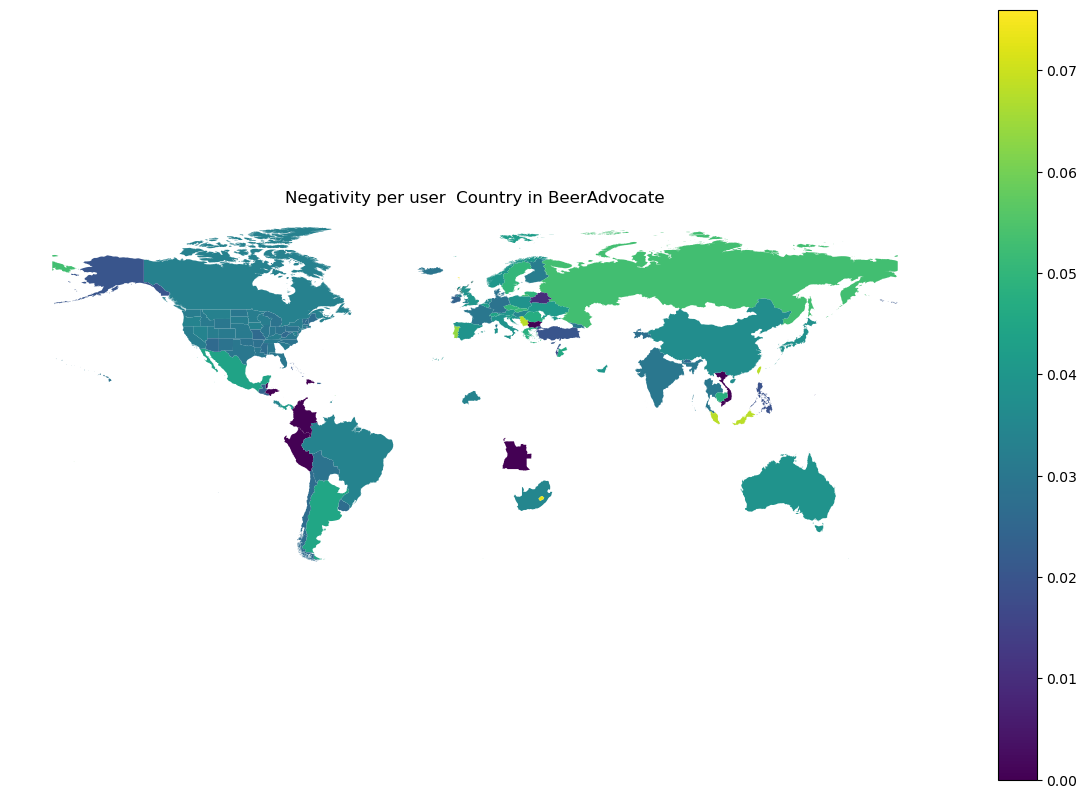

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
5,Ascension Island,"[0.118, 0.183, 0.176, 0.107, 0.045, 0.042, 0.1...",0.039112,0.000
16,Bosnia and Herzegovina,"[0.123, 0.351, 0.148, 0.204, 0.0, 0.0, 0.111, ...",0.040922,0.000
60,Laos,"[0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.021, 0.039,...",0.036333,0.023
65,Macedonia,"[0.0, 0.062, 0.0, 0.04, 0.024, 0.053, 0.0, 0.0...",0.047605,0.043
82,North Korea,"[0.145, 0.0, 0.053, 0.0, 0.111, 0.28, 0.272, 0...",0.048720,0.000
87,Palestine,"[0.128, 0.0, 0.102, 0.05, 0.0, 0.0, 0.0, 0.121]",0.050125,0.025
97,Saint Helena,"[0.145, 0.052, 0.049, 0.077, 0.025, 0.109, 0.0...",0.079220,0.076
107,South Korea,"[0.063, 0.0, 0.05, 0.077, 0.0, 0.031, 0.0, 0.0...",0.049282,0.019
112,Tanzania,"[0.066, 0.028, 0.0, 0.0, 0.09, 0.0, 0.078, 0.0...",0.019962,0.000
172,Virgin Islands (U.S.),"[0.0, 0.0, 0.0, 0.169, 0.072, 0.034, 0.114, 0....",0.042077,0.017


world_data :


,name,geometry,user_location,neg,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.0, 0.0, 0.0, 0.0, 0.087, 0.073, 0.0, 0.0, 0...",0.042390,0.000
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.0, 0.0, 0.0, 0.071, 0.0, 0.147, 0.098, 0.13...",0.042784,0.000
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,"[0.0, 0.0, 0.145, 0.0, 0.0, 0.0, 0.0, 0.136, 0...",0.052436,0.000
...,...,...,...,...,...,...
305,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.264, 0.087, 0.087, 0.181, 0.035, 0.627, 0.0...",0.039543,0.019
306,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.0, 0.0, 0.0, 0.136, 0.104, 0.0, 0.08, 0.08,...",0.055284,0.044
307,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.0, 0.0, 0.0, 0.069, 0.0, 0.127, 0.119, 0.0,...",0.045943,0.000
308,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.0, 0.047, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0....",0.051569,0.041


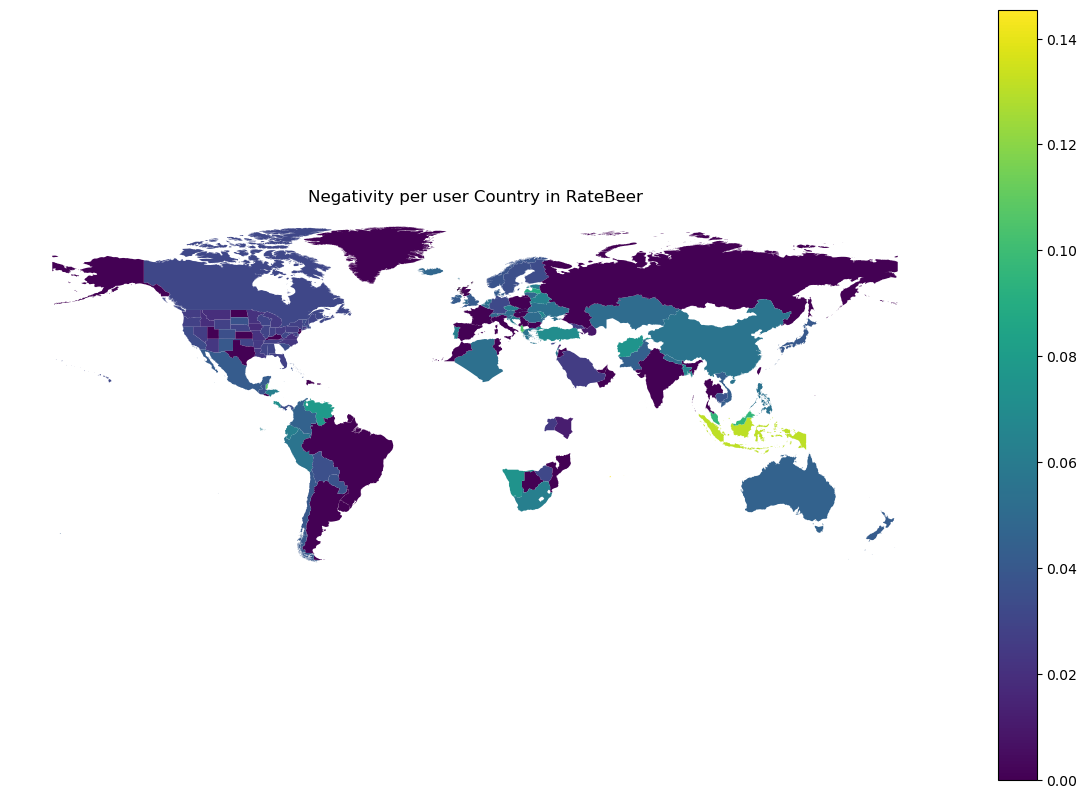

In [76]:
plot_map(df_neg_ba, shapefile, "Negativity per user ", "BeerAdvocate", 'median')
plot_map(df_neg_rb, shapefile, "Negativity per user", "RateBeer", 'median')


In [77]:
# sort df_neg_ba_brwe by median
df_neg_ba_brwe = df_neg_ba_brwe.sort_values(by='median', ascending=False)
df_pos_ba_brwe = df_pos_ba_brwe.sort_values(by='median', ascending=False)
df_neg_rb_brwe = df_neg_rb_brwe.sort_values(by='median', ascending=False)
df_pos_rb_brwe = df_pos_rb_brwe.sort_values(by='median', ascending=False)

# only keep the lines with more than 50 elements in neg
df_neg_ba_brwe_sh = df_neg_ba_brwe[df_neg_ba_brwe['neg'].apply(len) > 50]
df_pos_ba_brwe_sh = df_pos_ba_brwe[df_pos_ba_brwe['pos'].apply(len) > 50]
df_neg_rb_brwe_sh = df_neg_rb_brwe[df_neg_rb_brwe['neg'].apply(len) > 50]
df_pos_rb_brwe_sh = df_pos_rb_brwe[df_pos_rb_brwe['pos'].apply(len) > 50]


display(df_neg_ba_brwe)
#display(df_pos_ba_brwe)
#display(df_neg_rb_brwe)
#display(df_pos_rb_brwe)

#display(df_neg_ba_brwe_sh)
#display(df_pos_ba_brwe_sh)
#display(df_neg_rb_brwe_sh)
#display(df_pos_rb_brwe_sh)

# save the 10 first and last lines of each datafram in a csv
# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_ba_brwe_sh.head(10)
tail_n = df_neg_ba_brwe_sh.tail(10)
head_p = df_pos_ba_brwe_sh.head(10)
tail_p = df_pos_ba_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_ba_brwe.csv', index=False)

# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_rb_brwe_sh.head(10)
tail_n = df_neg_rb_brwe_sh.tail(10)
head_p = df_pos_rb_brwe_sh.head(10)
tail_p = df_pos_rb_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_rb_brwe.csv', index=False)

# oder df_neg_ba_brwe_sh by length of neg
df_neg_ba_brwe_sh = df_neg_ba_brwe_sh.sort_values(by='neg', ascending=False)


#display the 20 first lines
display(df_neg_ba_brwe_sh.head(20))

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[20:40])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[40:60])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[60:80])


#sort df_neg_ba_brwe_sh by mean
df_neg_ba_brwe_sh = df_neg_ba_brwe_sh.sort_values(by='mean', ascending=False)

#display the 20 first lines
display(df_neg_ba_brwe_sh.head(20))
#display the last 20 lines
display(df_neg_ba_brwe_sh.tail(20))

#sort df_neg_rb_brwe_sh by median
df_neg_rb_brwe_sh = df_neg_rb_brwe_sh.sort_values(by='median', ascending=False)

#display the 20 first lines
display(df_neg_rb_brwe_sh.head(20))

#display the last 20 lines
display(df_neg_rb_brwe_sh.tail(20))

# in df_work_ba, nb of countries with Miller brewery_name
print("nb of countries with Miller brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['user_location'].nunique())

# in df_work_ba, nb of countries with Anheuser-Bush brewery_name
print("nb of countries with Anheuser-Bush brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['user_location'].nunique())

# in df_work_ba, nb of countries with Heineken brewery_name
print("nb of countries with Heineken brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Heineken Nederland B.V.']['user_location'].nunique())

# in df_work_ba, nb of countries with Carlsberg brewery_name
print("nb of countries with Carlsberg brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Carlsberg Danmark A/S']['user_location'].nunique())

# in df_work_ba, nb of countries with Weihenstephan brewery_name
print("nb of countries with Weihenstephan brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['user_location'].nunique())

# in df_work_ba, nb of countries with Chimay brewery_name
print("nb of countries with Chimay brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bières de Chimay']['user_location'].nunique())








,brewery_name,neg,mean,median
1857,Cerveza Frontera,"[0.08, 0.1, 0.217, 0.183, 0.134, 0.172]",0.147667,0.153
2383,Efes-Vitanta-Moldova Brewery S.A.,"[0.177, 0.077, 0.124, 0.156, 0.18, 0.108, 0.21...",0.131125,0.140
3909,Lovely Valley Beverage Factory,"[0.074, 0.173, 0.152, 0.076, 0.176, 0.135, 0.2...",0.136182,0.135
2836,Global Brands Ltd.,"[0.053, 0.214, 0.0, 0.481, 0.027, 0.134, 0.0, ...",0.132667,0.134
6224,Toboggan Brewing Co.,"[0.14, 0.033, 0.179, 0.0, 0.135, 0.133, 0.139,...",0.095111,0.133
...,...,...,...,...
4823,Pints Brewing Co.,"[0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...",0.016545,0.000
4063,Mastry's Brewing Company,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000
1277,Braugaststätte Döbler,"[0.0, 0.052, 0.02, 0.0, 0.0, 0.067, 0.0, 0.0]",0.017375,0.000
2235,Devils Brewery,"[0.0, 0.0, 0.0, 0.044, 0.0, 0.0]",0.007333,0.000


,brewery_name,neg,mean,median
1815,Cervecería Polar,"[1.0, 0.092, 0.09, 0.037, 0.07, 0.024, 0.057, ...",0.080032,0.045
3767,Leech Lake Brewing Company,"[0.518, 0.048, 0.106, 0.036, 0.052, 0.029, 0.0...",0.055729,0.040
2605,Flat 12 Bierwerks,"[0.498, 0.046, 0.052, 0.06, 0.108, 0.158, 0.05...",0.051098,0.035
1167,Brau Union Österreich AG,"[0.412, 0.0, 0.049, 0.0, 0.03, 0.08, 0.045, 0....",0.050628,0.039
1697,Capital Brewery,"[0.403, 0.031, 0.032, 0.071, 0.098, 0.05, 0.04...",0.035685,0.029
976,Brains,"[0.325, 0.032, 0.045, 0.0, 0.042, 0.12, 0.058,...",0.046685,0.039
5328,Saint Archer Brewing Co.,"[0.307, 0.049, 0.033, 0.029, 0.041, 0.036, 0.0...",0.043224,0.035
5510,Silver Gulch Brewing and Bottling Co.,"[0.295, 0.021, 0.149, 0.06, 0.0, 0.016, 0.0, 0...",0.035962,0.025
2290,Dortmunder Actien Brauerei / DAB,"[0.291, 0.0, 0.091, 0.0, 0.0, 0.051, 0.072, 0....",0.042897,0.036
5360,San Miguel Brewery Inc.,"[0.291, 0.0, 0.035, 0.042, 0.075, 0.069, 0.025...",0.051992,0.043


,brewery_name,neg,mean,median
1681,Camo Brewing Company,"[0.139, 0.277, 0.0, 0.095, 0.024, 0.108, 0.05,...",0.094642,0.0880
5883,Tall Tales Brewing Company,"[0.054, 0.127, 0.0, 0.0, 0.0, 0.039, 0.212, 0....",0.091230,0.0650
1964,Coastal Fog Brewing,"[0.144, 0.051, 0.061, 0.01, 0.065, 0.157, 0.02...",0.084587,0.0720
3647,Krönleins Bryggeri AB,"[0.059, 0.045, 0.244, 0.038, 0.12, 0.084, 0.18...",0.083034,0.0630
4540,Oettinger Brauerei,"[0.022, 0.025, 0.007, 0.045, 0.0, 0.102, 0.133...",0.080450,0.0495
1815,Cervecería Polar,"[1.0, 0.092, 0.09, 0.037, 0.07, 0.024, 0.057, ...",0.080032,0.0450
1908,Chili Beer Co.,"[0.127, 0.0, 0.016, 0.0, 0.06, 0.0, 0.022, 0.0...",0.077891,0.0690
4222,MobCraft Beer,"[0.0, 0.0, 0.066, 0.164, 0.037, 0.338, 0.336, ...",0.076654,0.0460
5464,Shaw Wallace & Company Ltd.,"[0.09, 0.091, 0.021, 0.18, 0.154, 0.859, 0.039...",0.076442,0.0560
5331,Saint Ides Brewing Company,"[0.041, 0.038, 0.096, 0.341, 0.0, 0.05, 0.075,...",0.076397,0.0590


,brewery_name,neg,mean,median
3337,Icicle Brewing Company,"[0.01, 0.01, 0.046, 0.0, 0.0, 0.0, 0.0, 0.023,...",0.024500,0.0215
3195,Hofbräu Kaltenhausen (Brau Union),"[0.036, 0.094, 0.031, 0.039, 0.0, 0.024, 0.0, ...",0.024471,0.0175
6739,Yonkers Brewing Co.,"[0.008, 0.0, 0.0, 0.025, 0.034, 0.031, 0.0, 0....",0.024352,0.0245
1479,Brouwerij Rodenbach N.V.,"[0.052, 0.019, 0.065, 0.0, 0.038, 0.0, 0.029, ...",0.024289,0.0190
6417,Urban Artifact,"[0.0, 0.0, 0.04, 0.031, 0.179, 0.012, 0.051, 0...",0.024123,0.0120
1769,Central State Brewing,"[0.016, 0.048, 0.0, 0.0, 0.0, 0.0, 0.051, 0.0,...",0.023613,0.0100
5434,Second Self Beer Company,"[0.018, 0.047, 0.0, 0.0, 0.028, 0.074, 0.0, 0....",0.023579,0.0000
2830,Glacier Brewhouse,"[0.0, 0.027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.023569,0.0000
1366,BrickHouse Brewery,"[0.0, 0.077, 0.052, 0.055, 0.0, 0.0, 0.035, 0....",0.023438,0.0000
5850,"Swashbuckler Brewing Co, LTD","[0.068, 0.0, 0.067, 0.0, 0.04, 0.02, 0.0, 0.03...",0.023327,0.0170


,brewery_name,neg,mean,median
5533,Dolce Vela S.R.L.,"[0.211, 0.289, 0.157, 0.197, 0.098, 0.069, 0.2...",0.126458,0.1190
808,BIP-Beogradska Industrija Piva,"[0.158, 0.0, 0.263, 0.075, 0.092, 0.147, 0.114...",0.112920,0.1180
15046,Valge Pruulikoda,"[0.045, 0.125, 0.291, 0.115, 0.196, 0.034, 0.2...",0.133031,0.1015
10448,Mõtsalise Pruulikoda,"[0.0, 0.0, 0.11, 0.076, 0.078, 0.182, 0.146, 0...",0.098962,0.1005
5953,Eridan,"[0.052, 0.05, 0.153, 0.135, 0.097, 0.239, 0.21...",0.100193,0.0970
11753,Pivzavod AO Hamovniki,"[0.0, 0.206, 0.174, 0.095, 0.027, 0.124, 0.212...",0.101931,0.0970
15009,Urwibutso Enterprise,"[0.0, 0.226, 0.295, 0.13, 0.036, 0.0, 0.132, 0...",0.108190,0.0970
12396,Reschs (CUB),"[0.0, 0.0, 0.035, 0.147, 0.127, 0.035, 0.178, ...",0.109376,0.0950
13242,Shirak Gyumri Beer-Malt Factory CJSC,"[0.169, 0.147, 0.151, 0.062, 0.0, 0.275, 0.189...",0.103049,0.0940
7702,Holu,"[0.175, 0.15, 0.085, 0.12, 0.057, 0.206, 0.09,...",0.111949,0.0940


,brewery_name,neg,mean,median
15536,Wild Heaven Craft Beers,"[0.055, 0.039, 0.06, 0.0, 0.039, 0.0, 0.0, 0.0...",0.029694,0.0
4988,Cotoya,"[0.041, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044, 0.084,...",0.037886,0.0
14443,Three Barrel Brewing Company,"[0.085, 0.0, 0.0, 0.0, 0.053, 0.0, 0.062, 0.0,...",0.041414,0.0
14441,Three 3s Brewing Company,"[0.099, 0.075, 0.0, 0.0, 0.0, 0.0, 0.0, 0.073,...",0.028492,0.0
7419,Heavy Riff Brewing Company,"[0.0, 0.065, 0.0, 0.056, 0.023, 0.0, 0.044, 0....",0.033007,0.0
14439,Thr3e Wise Men,"[0.115, 0.0, 0.0, 0.026, 0.048, 0.089, 0.026, ...",0.036676,0.0
267,Adventure Brewing Company,"[0.0, 0.229, 0.0, 0.0, 0.0, 0.063, 0.0, 0.0, 0...",0.041736,0.0
6373,Forager Brewing Company,"[0.0, 0.0, 0.0, 0.032, 0.0, 0.0, 0.038, 0.05, ...",0.031321,0.0
5004,County Line Brewing,"[0.0, 0.0, 0.0, 0.049, 0.0, 0.017, 0.0, 0.0, 0...",0.026424,0.0
7427,Hechtbräu Zimmern,"[0.149, 0.0, 0.0, 0.086, 0.0, 0.061, 0.0, 0.0,...",0.048481,0.0


nb of countries with Miller brewery_name :


88

nb of countries with Anheuser-Bush brewery_name :


102

nb of countries with Heineken brewery_name :


102

nb of countries with Carlsberg brewery_name :


83

nb of countries with Weihenstephan brewery_name :


101

nb of countries with Chimay brewery_name :


105

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
2,Antarctica,"[0.056, 0.143, 0.112, 0.052, 0.183, 0.194, 0.2...",0.139743,0.1360
3,Aotearoa,"[0.155, 0.092, 0.232, 0.111, 0.183, 0.138, 0.2...",0.146256,0.1360
15,Bosnia and Herzegovina,"[0.206, 0.052, 0.04, 0.08, 0.072, 0.059, 0.225...",0.133074,0.1120
34,Fiji Islands,"[0.145, 0.161, 0.169, 0.143, 0.054, 0.225, 0.1...",0.140170,0.1430
57,Macedonia,"[0.076, 0.18, 0.241, 0.175, 0.156, 0.153, 0.14...",0.156250,0.1545
77,South Georgia and South Sandwich Islands,"[0.149, 0.13, 0.147, 0.137, 0.083, 0.155, 0.08...",0.122938,0.1335
84,Tanzania,"[0.043, 0.081, 0.193, 0.12, 0.245, 0.206, 0.05...",0.156700,0.1590


world_data :


,name,geometry,user_location,pos,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.229, 0.085, 0.136, 0.056, 0.107, 0.323, 0.3...",0.144129,0.140
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.215, 0.221, 0.252, 0.106, 0.09, 0.115, 0.20...",0.120252,0.112
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,"[0.328, 0.17, 0.164, 0.306, 0.183, 0.559, 0.27...",0.265667,0.276
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.269, 0.153, 0.198, 0.188, 0.109, 0.064, 0.1...",0.160423,0.149
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.21, 0.253, 0.272, 0.125, 0.077, 0.268, 0.25...",0.157827,0.157
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.114, 0.097, 0.096, 0.133, 0.167, 0.088, 0.1...",0.158117,0.152
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.243, 0.067, 0.0, 0.108, 0.096, 0.099, 0.086...",0.145368,0.137


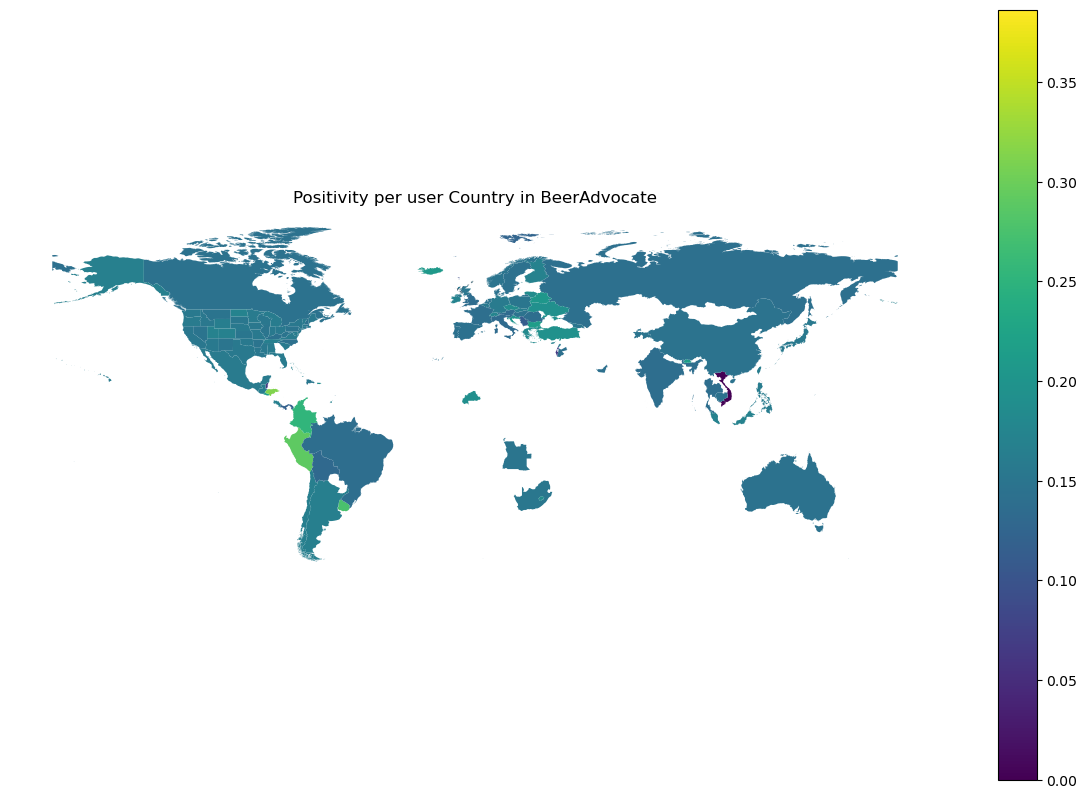

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
5,Ascension Island,"[0.04, 0.117, 0.071, 0.126, 0.136, 0.385, 0.04...",0.151517,0.1400
16,Bosnia and Herzegovina,"[0.192, 0.0, 0.045, 0.13, 0.0, 0.222, 0.0, 0.1...",0.131482,0.0330
60,Laos,"[0.288, 0.044, 0.049, 0.13, 0.116, 0.091, 0.09...",0.125000,0.0965
65,Macedonia,"[0.176, 0.278, 0.455, 0.086, 0.465, 0.369, 0.0...",0.189349,0.1760
82,North Korea,"[0.0, 0.221, 0.197, 0.208, 0.207, 0.0, 0.0, 0....",0.133195,0.1270
87,Palestine,"[0.153, 0.062, 0.275, 0.258, 0.261, 0.468, 0.4...",0.256750,0.2595
97,Saint Helena,"[0.122, 0.0, 0.0, 0.197, 0.118, 0.167, 0.226, ...",0.098417,0.0910
107,South Korea,"[0.116, 0.291, 0.167, 0.153, 0.293, 0.065, 0.1...",0.176475,0.1670
112,Tanzania,"[0.169, 0.157, 0.204, 0.128, 0.213, 0.214, 0.1...",0.180385,0.1785
172,Virgin Islands (U.S.),"[0.3, 0.21, 0.312, 0.108, 0.113, 0.233, 0.267,...",0.217667,0.2160


world_data :


,name,geometry,user_location,pos,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.094, 0.0, 0.108, 0.129, 0.168, 0.073, 0.081...",0.095440,0.061
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.045, 0.05, 0.074, 0.076, 0.0, 0.058, 0.122,...",0.147315,0.138
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,"[0.345, 0.246, 0.0, 0.0, 0.0, 0.146, 0.0, 0.0,...",0.048353,0.000
...,...,...,...,...,...,...
305,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.081, 0.124, 0.062, 0.184, 0.079, 0.0, 0.182...",0.167741,0.160
306,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.508, 0.211, 0.075, 0.185, 0.0, 0.086, 0.0, ...",0.149701,0.141
307,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.0, 0.15, 0.097, 0.0, 0.167, 0.101, 0.0, 0.0...",0.135762,0.132
308,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.085, 0.121, 0.164, 0.202, 0.0, 0.138, 0.025...",0.140811,0.133


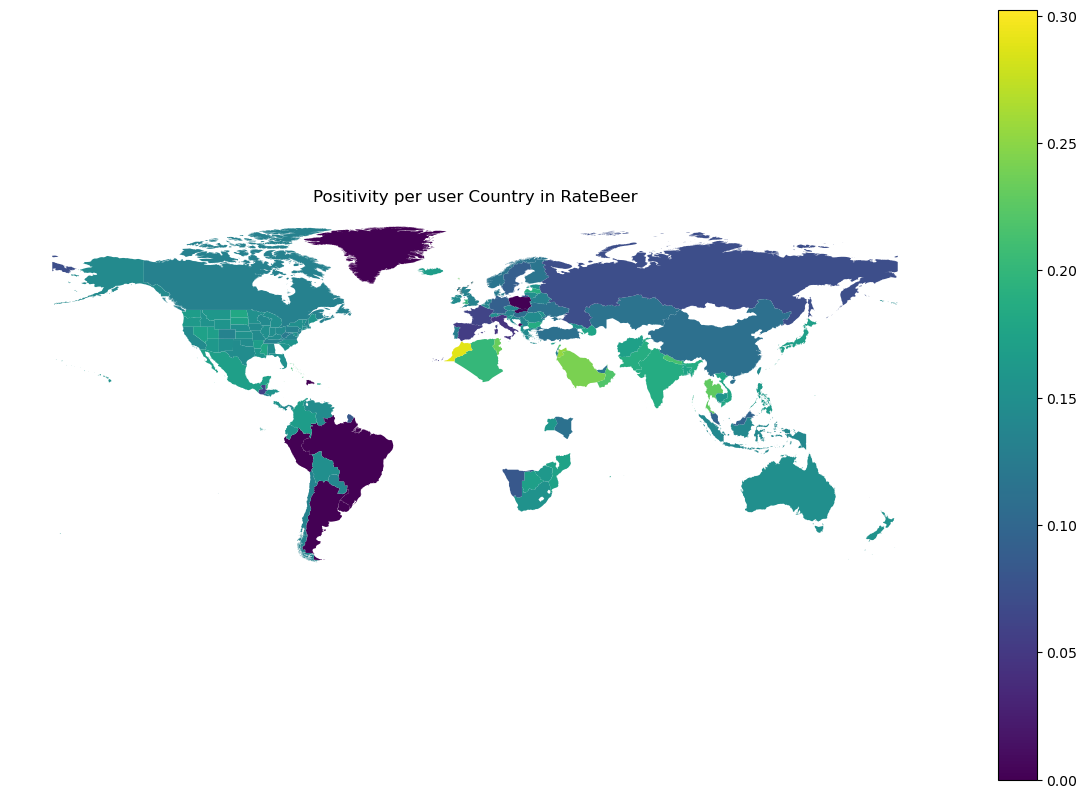

In [79]:
plot_map(df_pos_ba, shapefile, "Positivity per user", "BeerAdvocate", 'median')
plot_map(df_pos_rb, shapefile, "Positivity per user", "RateBeer",'median')

In [80]:
display(df_work_ba)

# create a new df with brewery_name, user_location, neg, pos
df_ba_brwe_loc = df_work_ba[['brewery_name', 'user_location', 'neg', 'pos']]
df_rb_brwe_loc = df_work_rb[['brewery_name', 'user_location', 'neg', 'pos']]

# create a new df with all the unique countries and add a column negs and poss
df_ba_brwe_loc_unique = df_ba_brwe_loc[['user_location']].drop_duplicates()
df_ba_brwe_loc_unique['negs'] = ''
df_ba_brwe_loc_unique['poss'] = ''

# create a new df with all the unique countries and add a column negs and poss
df_rb_brwe_loc_unique = df_rb_brwe_loc[['user_location']].drop_duplicates()
df_rb_brwe_loc_unique['negs'] = ''
df_rb_brwe_loc_unique['poss'] = ''


# for each country, put the neg and pos of all appearences of Weihenstaphan in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_ba_brwe_loc_unique.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_rb_brwe_loc_unique.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()



# for each country, put the neg and pos of all appearences of Miller in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['neg'].tolist()
    df_ba_brwe_loc_unique.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['neg'].tolist()
    df_rb_brwe_loc_unique.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['pos'].tolist()



# remove the lines where negs are empty (neg and pos are always generated together)
df_ba_brwe_loc_unique = df_ba_brwe_loc_unique[df_ba_brwe_loc_unique['negs'].apply(len) > 0]

    
    

# take the mean of the negs and put in new column neg
df_ba_brwe_loc_unique['neg'] = df_ba_brwe_loc_unique['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_ba_brwe_loc_unique['pos'] = df_ba_brwe_loc_unique['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_rb_brwe_loc_unique['neg'] = df_rb_brwe_loc_unique['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_rb_brwe_loc_unique['pos'] = df_rb_brwe_loc_unique['poss'].apply(np.mean)


# create a df_comp with the country and the difference between the mean of the country and neg of df_ba_brwe_loc_unique
df_comp_neg_ba = df_ba_brwe_loc_unique[['user_location', 'neg']]
df_comp_neg_ba['diff'] = df_comp_neg_ba['neg'] - df_comp_neg_ba['neg'].mean()
df_comp_pos_ba = df_ba_brwe_loc_unique[['user_location', 'pos']]
df_comp_pos_ba['diff'] = df_comp_pos_ba['pos'] - df_comp_pos_ba['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_rb_brwe_loc_unique
df_comp_rb = df_rb_brwe_loc_unique[['user_location', 'neg']]
df_comp_rb['diff'] = df_comp_rb['neg'] - df_comp_rb['neg'].mean()
df_comp_pos_rb = df_rb_brwe_loc_unique[['user_location', 'pos']]
df_comp_pos_rb['diff'] = df_comp_pos_rb['pos'] - df_comp_pos_rb['pos'].mean()




display(df_ba_brwe_loc_unique)
display(df_comp_pos_ba)
display(df_comp_neg_ba)
display(df_comp_rb)
display(df_comp_pos_rb)


,beer_name,brewery_name,style,abv,overall,rating,text,user_location,brewery_location,nbr_beers_by_brewery,zscore,compound,neg,neu,pos
0,Régab,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,3.0,23.887872,"From a bottle, pours a piss yellow color with ...","United States, Washington",Gabon,1,-1.535859,-0.4312,0.139,0.763,0.098
1,Barelegs Brew,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,3.5,49.430863,Pours pale copper with a thin head that quickl...,"United States, New York",Northern Ireland,5,-0.528719,0.5829,0.0,0.904,0.096
2,Barelegs Brew,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,3.5,51.895117,"500ml Bottle bought from The Vintage, Antrim.....",Northern Ireland,Northern Ireland,5,-0.431555,0.9506,0.0,0.79,0.21
3,Barelegs Brew,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4.5,63.044792,Serving: 500ml brown bottlePour: Good head wit...,Northern Ireland,Northern Ireland,5,0.008068,0.9623,0.049,0.698,0.253
4,Barelegs Brew,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4.0,64.000000,"500ml bottlePours with a light, slightly hazy ...",Northern Ireland,Northern Ireland,5,0.045731,0.9153,0.0,0.728,0.272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503075,Irvington Pale Ale,Summit Station Restaurant & Brewery,American Pale Ale (APA),6.8,3.5,32.157432,"It may say APA on this site, but talking to th...","United States, Rhode Island","United States, Maryland",13,-1.209796,-0.7235,0.147,0.747,0.106
2503076,Kölsch Ale,Summit Station Restaurant & Brewery,Kölsch,5.0,4.0,54.872000,I'll start off reviewing this beer with the fo...,"United States, Connecticut","United States, Maryland",13,-0.314179,-0.0917,0.049,0.905,0.046
2503077,Kölsch Ale,Summit Station Restaurant & Brewery,Kölsch,5.0,3.0,21.952000,Served on draft at the pub. Poured a clear yel...,"United States, Maryland","United States, Maryland",13,-1.612189,0.7292,0.095,0.706,0.198
2503078,Kölsch Ale,Summit Station Restaurant & Brewery,Kölsch,5.0,1.5,3.652264,Served on tap at the brewpub in a pint glass.A...,"United States, Virginia","United States, Maryland",13,-2.333733,0.3573,0.051,0.866,0.083


100%|██████████| 221/221 [04:21<00:00,  1.18s/it]
c:\Users\ben\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ben\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1054595016.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_neg_ba['diff'] = df_comp_neg_ba['neg'] - df_comp_neg_ba['neg'].mean()
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1054595016.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,user_location,negs,poss,neg,pos
0,"United States, Washington","[0.0, 0.133, 0.039, 0.0, 0.086, 0.049, 0.081, ...","[0.199, 0.074, 0.236, 0.228, 0.137, 0.252, 0.0...",0.064396,0.126569
1,"United States, New York","[0.033, 0.028, 0.068, 0.038, 0.068, 0.036, 0.0...","[0.215, 0.095, 0.205, 0.228, 0.219, 0.164, 0.0...",0.069406,0.124923
2,Northern Ireland,"[0.072, 0.107, 0.0, 0.199, 0.095]","[0.287, 0.119, 0.106, 0.128, 0.028]",0.094600,0.133600
5,"United States, North Carolina","[0.064, 0.026, 0.039, 0.028, 0.0, 0.108, 0.036...","[0.2, 0.114, 0.156, 0.055, 0.09, 0.129, 0.085,...",0.062798,0.135574
7,"United States, Illinois","[0.028, 0.03, 0.077, 0.077, 0.044, 0.027, 0.04...","[0.055, 0.098, 0.126, 0.108, 0.16, 0.208, 0.14...",0.070643,0.130125
...,...,...,...,...,...
48545,Argentina,[0.147],[0.062],0.147000,0.062000
49250,Israel,[0.046],[0.113],0.046000,0.113000
71085,Isle of Man,"[0.152, 0.018, 0.015]","[0.198, 0.153, 0.14]",0.061667,0.163667
83993,Peru,[0.192],[0.414],0.192000,0.414000


,user_location,pos,diff
0,"United States, Washington",0.126569,0.003923
1,"United States, New York",0.124923,0.002276
2,Northern Ireland,0.133600,0.010953
5,"United States, North Carolina",0.135574,0.012927
7,"United States, Illinois",0.130125,0.007478
...,...,...,...
48545,Argentina,0.062000,-0.060647
49250,Israel,0.113000,-0.009647
71085,Isle of Man,0.163667,0.041020
83993,Peru,0.414000,0.291353


,user_location,neg,diff
0,"United States, Washington",0.064396,-0.006765
1,"United States, New York",0.069406,-0.001755
2,Northern Ireland,0.094600,0.023439
5,"United States, North Carolina",0.062798,-0.008363
7,"United States, Illinois",0.070643,-0.000518
...,...,...,...
48545,Argentina,0.147000,0.075839
49250,Israel,0.046000,-0.025161
71085,Isle of Man,0.061667,-0.009494
83993,Peru,0.192000,0.120839


,user_location,neg,diff
0,Poland,NaN,NaN
1,Spain,NaN,NaN
4,Germany,NaN,NaN
9,Belgium,NaN,NaN
10,"United States, Connecticut",NaN,NaN
...,...,...,...
5808088,Saint Lucia,NaN,NaN
5871203,Micronesia,NaN,NaN
5875960,Virgin Islands (British),NaN,NaN
5962729,Yemen,NaN,NaN


,user_location,pos,diff
0,Poland,NaN,NaN
1,Spain,NaN,NaN
4,Germany,NaN,NaN
9,Belgium,NaN,NaN
10,"United States, Connecticut",NaN,NaN
...,...,...,...
5808088,Saint Lucia,NaN,NaN
5871203,Micronesia,NaN,NaN
5875960,Virgin Islands (British),NaN,NaN
5962729,Yemen,NaN,NaN


Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5832,Antarctica,0.080667,-0.04198


world_data :


,name,geometry,user_location,pos,diff
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,0.000000,-0.122647
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN
...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,0.105077,-0.017570
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,0.133600,0.010953
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,0.113500,-0.009147
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,0.156526,0.033879


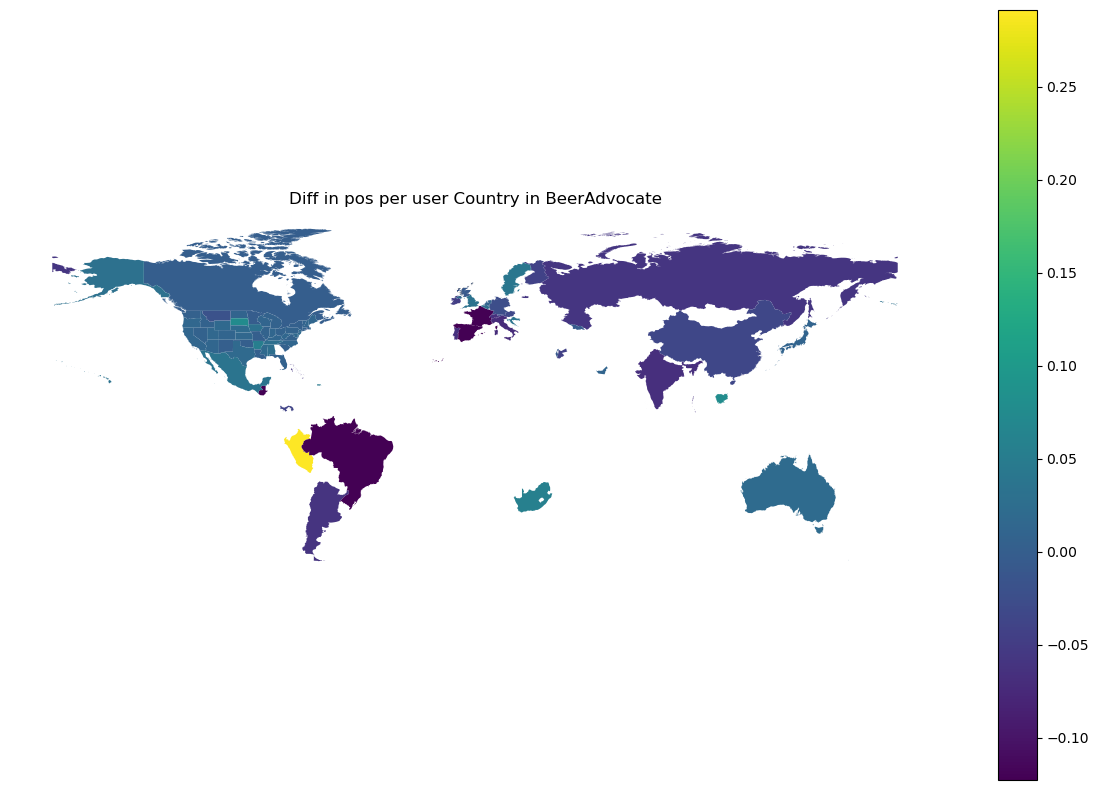

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5832,Antarctica,0.058,-0.013161


world_data :


,name,geometry,user_location,neg,diff
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,0.057000,-0.014161
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN
...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,0.036077,-0.035084
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,0.094600,0.023439
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,0.061500,-0.009661
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,0.077474,0.006313


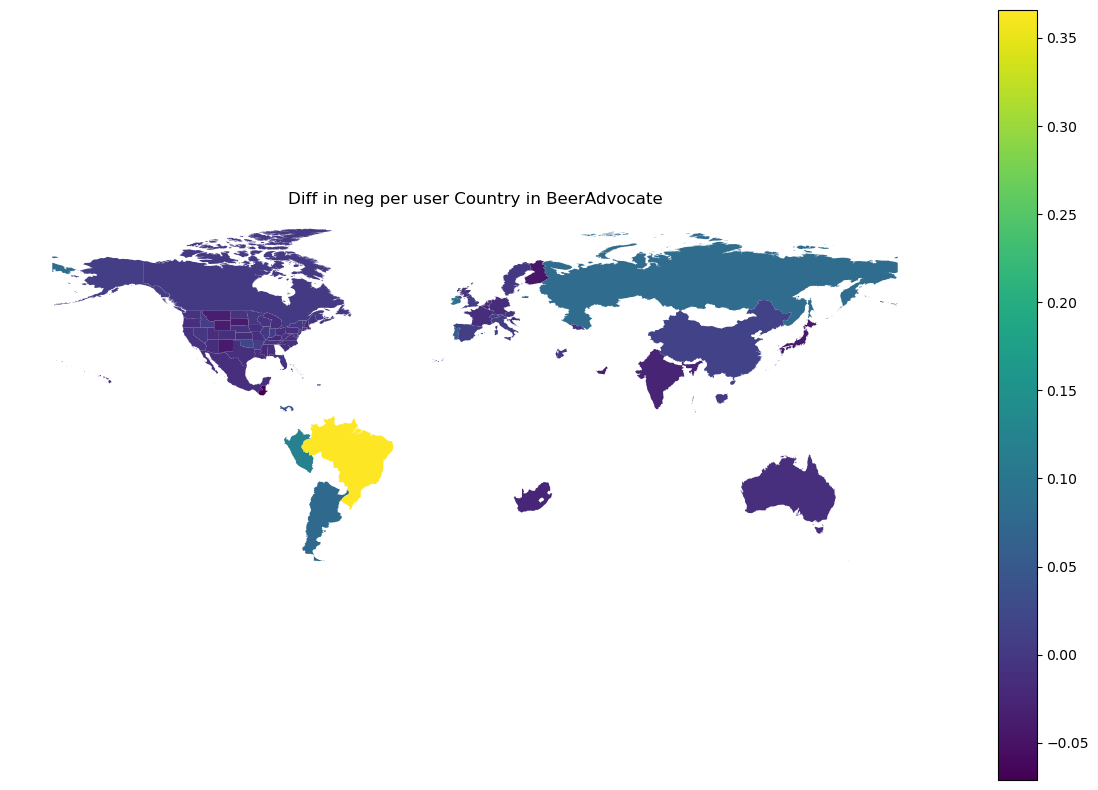

In [81]:

#display(df_comp)
plot_map(df_comp_pos_ba, shapefile, "Diff in pos per user", "BeerAdvocate", 'diff')
plot_map(df_comp_neg_ba, shapefile, "Diff in neg per user", "BeerAdvocate", 'diff')

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5121,Ascension Island,NaN,NaN
6304,North Korea,NaN,NaN
6971,South Korea,NaN,NaN
20002,Laos,NaN,NaN
22744,Bosnia and Herzegovina,NaN,NaN
22813,Macedonia,NaN,NaN
128437,Abkhazia,NaN,NaN
209550,Virgin Islands (U.S.),NaN,NaN
448004,Antigua and Barbuda,NaN,NaN
465794,Saint Helena,NaN,NaN


world_data :


,name,geometry,user_location,pos,diff
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,NaN,NaN
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,NaN,NaN
...,...,...,...,...,...
306,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,NaN,NaN
307,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,NaN,NaN
308,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,NaN,NaN
309,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,NaN,NaN


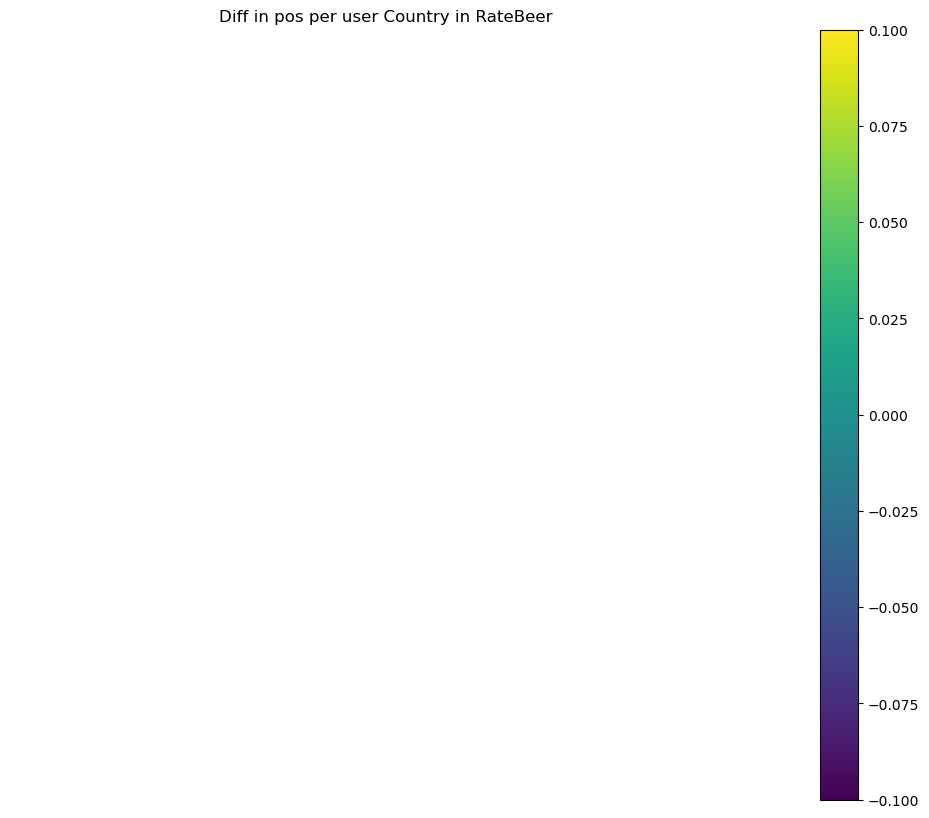

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3876751243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5121,Ascension Island,NaN,NaN
6304,North Korea,NaN,NaN
6971,South Korea,NaN,NaN
20002,Laos,NaN,NaN
22744,Bosnia and Herzegovina,NaN,NaN
22813,Macedonia,NaN,NaN
128437,Abkhazia,NaN,NaN
209550,Virgin Islands (U.S.),NaN,NaN
448004,Antigua and Barbuda,NaN,NaN
465794,Saint Helena,NaN,NaN


world_data :


,name,geometry,user_location,neg,diff
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,NaN,NaN
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",Uruguay,NaN,NaN
...,...,...,...,...,...
306,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,NaN,NaN
307,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,NaN,NaN
308,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,NaN,NaN
309,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,NaN,NaN


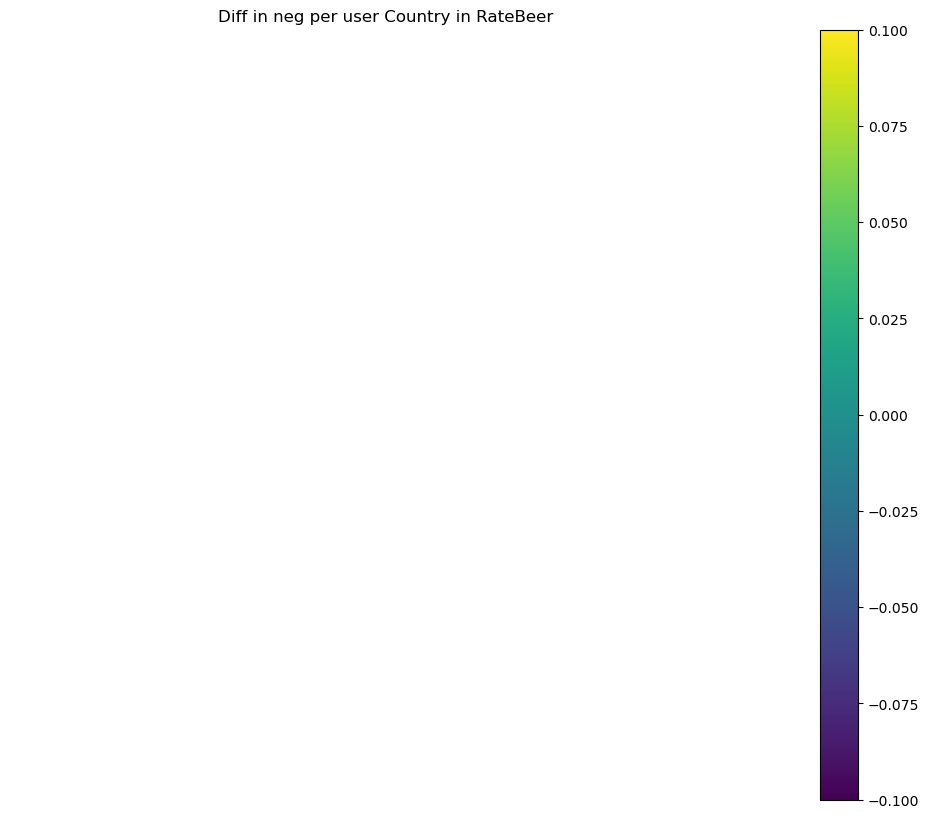

In [82]:
plot_map(df_comp_pos_rb, shapefile, "Diff in pos per user", "RateBeer", 'diff')
plot_map(df_comp_rb, shapefile, "Diff in neg per user", "RateBeer", 'diff')


In [25]:
import pickle

# Open the pickle file in read mode
with open('variables/frac_per_loc_per_cat_2.pickle', 'rb') as file:
    dictionary_data2 = pickle.load(file)

with open('variables/frac_per_loc_per_cat.pickle', 'rb') as file:
    dictionary_data = pickle.load(file)
display(dictionary_data)
display(dictionary_data2)


{'California': {'STOUTS': 0.117035285879605,
  'SOURS': 0.017912703249688106,
  'PALE_ALES': 0.5646560706139874},
 'Pennsylvania': {'STOUTS': 0.12080384031733503,
  'SOURS': 0.017730763205409988,
  'BELGIANS': 0.05230919862505806},
 'Canada': {'STOUTS': 0.09366529138224722,
  'BELGIANS': 0.03925869049928479,
  'SOURS': 0.014048274345914498},
 'Illinois': {'STOUTS': 0.12718828163860543,
  'SOURS': 0.017846673245060417,
  'PALE_ALES': 0.4677590638033792},
 'New York': {'STOUTS': 0.10480291142013856,
  'SOURS': 0.017489864749873227,
  'BELGIANS': 0.032880680729820644},
 'Denmark': {'SOURS': 0.012503038447254915,
  'STOUTS': 0.11068725816048124,
  'PORTERS': 0.04356086728464482},
 'Texas': {'STOUTS': 0.15003011486660334,
  'PORTERS': 0.07307764680822927,
  'SOURS': 0.017825623803868693},
 'England': {'SOURS': 0.004834849615020088,
  'STOUTS': 0.10305647546876606,
  'BELGIANS': 0.007102407533712865},
 'Massachusetts': {'STOUTS': 0.08683606494797487,
  'SOURS': 0.006052489177489177,
  'PALE_

{'California': {'PALE_ALES': 0.5646560706139874,
  'STOUTS': 0.117035285879605,
  'BELGIANS': 0.03629521489503969},
 'Pennsylvania': {'PALE_ALES': 0.4935732250349855,
  'STOUTS': 0.12080384031733503,
  'LAGERS': 0.06513239305369668},
 'Canada': {'PALE_ALES': 0.47739482354203605,
  'OTHER': 0.1231586439027593,
  'LAGERS': 0.11404553063489485},
 'Illinois': {'PALE_ALES': 0.4677590638033792,
  'STOUTS': 0.12718828163860543,
  'OTHER': 0.0846310801483233},
 'New York': {'PALE_ALES': 0.6043525627336483,
  'STOUTS': 0.10480291142013856,
  'LAGERS': 0.04951856455355951},
 'Denmark': {'PALE_ALES': 0.2783073124560914,
  'LAGERS': 0.15287537915161775,
  'OTHER': 0.13482288401762385},
 'Texas': {'PALE_ALES': 0.4694198881606687,
  'STOUTS': 0.15003011486660334,
  'LAGERS': 0.06132910802876764},
 'England': {'PALE_ALES': 0.7210911674483139,
  'STOUTS': 0.10305647546876606,
  'LAGERS': 0.019109629402984295},
 'Massachusetts': {'PALE_ALES': 0.6502957800153937,
  'STOUTS': 0.08683606494797487,
  'LAGE

check for the styles for the 2 breweries


In [86]:
# open as a dcitionary the file best_cat_per_user_location
with open('variables/best_cat_per_user_location.pickle', 'rb') as file:
    dictionary_data3 = pickle.load(file)

display(dictionary_data3)

# transform the dictionary into a dataframe
df_best_cat = pd.DataFrame.from_dict(dictionary_data3, orient='index')
df_best_cat.reset_index(inplace=True)
df_best_cat.rename({'index':'user_location', 0:'best_cat'}, inplace=True, axis=1)
display(df_best_cat)

locations = df_best_cat['user_location'].unique()

# Creating an empty DataFrame to store the results
new_df = pd.DataFrame({'user_location': locations})

# Iterating through each row to extract the top 3 styles with non-NaN values
for idx, row in df_best_cat.iterrows():
    # Extracting the non-NaN values for each row and sorting them by descending order
    non_nan_styles = row.drop('user_location').dropna().sort_values(ascending=False)
    
    # Selecting the top 3 styles (or less if there are fewer than 3)
    top_styles = non_nan_styles[:3]
    
    # Filling the corresponding columns in the new DataFrame
    new_df.loc[idx, 'Top1'] = top_styles.index[0] if len(top_styles) >= 1 else None
    new_df.loc[idx, 'Top2'] = top_styles.index[1] if len(top_styles) >= 2 else None
    new_df.loc[idx, 'Top3'] = top_styles.index[2] if len(top_styles) >= 3 else None

print(new_df)



{'California': STOUTS       0.591949
 SOURS        0.447969
 PALE_ALES    0.380837
 dtype: float64,
 'Pennsylvania': STOUTS      0.540875
 SOURS       0.453722
 BELGIANS    0.374156
 dtype: float64,
 'Canada': STOUTS      0.454295
 BELGIANS    0.379139
 SOURS       0.377731
 dtype: float64,
 'Illinois': STOUTS       0.589677
 SOURS        0.389470
 PALE_ALES    0.339895
 dtype: float64,
 'New York': STOUTS      0.504115
 SOURS       0.446456
 BELGIANS    0.366715
 dtype: float64,
 'Denmark': SOURS      0.965848
 STOUTS     0.864513
 PORTERS    0.685149
 dtype: float64,
 'Texas': STOUTS     0.563816
 PORTERS    0.357421
 SOURS      0.336688
 dtype: float64,
 'England': SOURS       0.456419
 STOUTS      0.452801
 BELGIANS    0.367406
 dtype: float64,
 'Massachusetts': STOUTS       0.528037
 SOURS        0.464210
 PALE_ALES    0.369456
 dtype: float64,
 'Ohio': STOUTS      0.619405
 SOURS       0.444840
 BELGIANS    0.406285
 dtype: float64,
 'New Jersey': STOUTS      0.535452
 SOURS     

,user_location,STOUTS,SOURS,PALE_ALES,BELGIANS,PORTERS,BROWNS
0,California,0.591949,0.447969,0.380837,NaN,NaN,NaN
1,Pennsylvania,0.540875,0.453722,NaN,0.374156,NaN,NaN
2,Canada,0.454295,0.377731,NaN,0.379139,NaN,NaN
3,Illinois,0.589677,0.389470,0.339895,NaN,NaN,NaN
4,New York,0.504115,0.446456,NaN,0.366715,NaN,NaN
...,...,...,...,...,...,...,...
114,Marshall Islands,NaN,NaN,0.807344,NaN,0.869998,1.917219
115,Slovenia,NaN,NaN,NaN,0.543695,0.391817,0.456072
116,El Salvador,NaN,NaN,NaN,0.275025,0.242520,0.448691
117,Dominican Republic,NaN,NaN,NaN,-0.187668,0.467065,1.014289


          user_location      Top1      Top2       Top3
0            California    STOUTS     SOURS  PALE_ALES
1          Pennsylvania    STOUTS     SOURS   BELGIANS
2                Canada    STOUTS  BELGIANS      SOURS
3              Illinois    STOUTS     SOURS  PALE_ALES
4              New York    STOUTS     SOURS   BELGIANS
..                  ...       ...       ...        ...
114    Marshall Islands    BROWNS   PORTERS  PALE_ALES
115            Slovenia  BELGIANS    BROWNS    PORTERS
116         El Salvador    BROWNS  BELGIANS    PORTERS
117  Dominican Republic    BROWNS   PORTERS   BELGIANS
118              Jersey   PORTERS  BELGIANS     BROWNS

[119 rows x 4 columns]


In [88]:
# display all the styles of Miller Brewing Co. in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['style'].unique())

# display all the styles of Anheuser-Bush in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['style'].unique())

# display all the styles of Weihenstephan in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['style'].unique())


array(['American Adjunct Lager', 'Herbed / Spiced Beer',
       'American Malt Liquor', 'Light Lager',
       'American Amber / Red Lager', 'American Amber / Red Ale',
       'American Blonde Ale', 'American Pale Wheat Ale',
       'Fruit / Vegetable Beer', 'Low Alcohol Beer'], dtype=object)

array(['American Amber / Red Lager', 'Fruit / Vegetable Beer',
       'Euro Pale Lager', 'Dunkelweizen', 'Irish Dry Stout',
       'German Pilsener', 'American Pale Lager', 'American Blonde Ale',
       'Herbed / Spiced Beer', 'Cream Ale', 'Doppelbock',
       'American Adjunct Lager', 'Light Lager', 'American Malt Liquor',
       'American Amber / Red Ale', 'Low Alcohol Beer',
       'Munich Helles Lager', 'American IPA', 'Pumpkin Ale',
       'American Double / Imperial Pilsner', 'Bock', 'Hefeweizen',
       'Black & Tan', 'Euro Dark Lager', 'American Pale Wheat Ale',
       'Irish Red Ale', 'Märzen / Oktoberfest', 'English Pale Ale',
       'American Porter', 'Winter Warmer', 'Oatmeal Stout',
       'American Pale Ale (APA)', 'Rye Beer', 'Witbier',
       'American Dark Wheat Ale', 'American Brown Ale', 'Czech Pilsener',
       'Kölsch'], dtype=object)

array(['Kellerbier / Zwickelbier', 'Hefeweizen', 'Märzen / Oktoberfest',
       'Low Alcohol Beer', 'Dunkelweizen', 'Maibock / Helles Bock',
       'Doppelbock', 'Kristalweizen', 'Weizenbock', 'Munich Helles Lager',
       'American Pale Ale (APA)', 'German Pilsener',
       'Munich Dunkel Lager', 'English Brown Ale'], dtype=object)

Basic Explorations

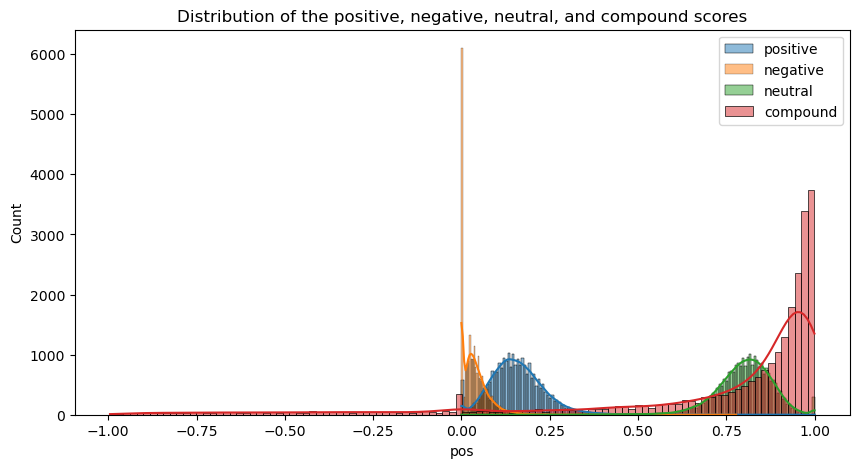

In [ ]:
# plot the distribution of the positive, negative, neutral, and compound scores
plt.figure(figsize=(10, 5))
plt.title('Distribution of the positive, negative, neutral, and compound scores')

sns.histplot(data=df_ba_new, x='pos', label='positive', kde=True)
sns.histplot(data=df_ba_new, x='neg', label='negative', kde=True)
sns.histplot(data=df_ba_new, x='neu', label='neutral', kde=True)
sns.histplot(data=df_ba_new, x='compound', label='compound', kde=True)

plt.legend()
plt.show()



In [ ]:
b_rev = 'this is the worst beer I have ever tasted'
g_rev = 'this is the best beer I have ever tasted'
print(analyzer.polarity_scores(b_rev))
print(analyzer.polarity_scores(g_rev))


{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}
